<a href="https://colab.research.google.com/github/viriditass/Papers/blob/main/CornerNet_Detecting_Objects_as_Paired_Keypoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CornerNet: Detecting Objects as Paired Keypoints**

논문 링크: https://arxiv.org/abs/1808.01244

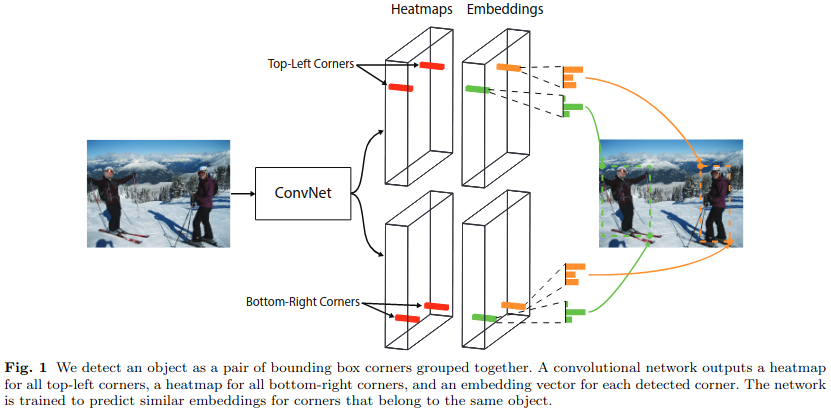

본 논문은 CornerNet을 제안한다. CornerNet은 두 쌍의 keypoints(이미지의 top-left corner & bottom-right corner)를 사용해 위의 그림 Figure 1과 같이 object의 bbox를 예측하는 model이다. **keypoints를 사용하기 때문에 anchor box가 필요없다**는 점이 특징이다.

그러면 본 논문은 왜 굳이 anchor box를 없애고 keypoint를 사용할까? 바로 anchor box에 아래와 같이 두 가지 단점이 있기 때문이다.
1. 엄첨 많은 anchor box를 생성해야 한다. 그 중 GT box와 일정 IoU 이상인 anchor box만 positive에 할당하게 되는데, 이 과정 속에서 positive, negative imbalance 문제고 발생한다. 즉, 많은 수의 anchor box 중에 소수만 positive가 되는 것이다.
2. anchor box를 설계하는 과정에서 여러 hyper-parameter를 고려해야 한다. anchor box의 size, aspect ratio, scale 등 고려 사항이 많다.

따라서 CornerNet은 이렇게 번거스러운 anchor box를 제거하고, keypoint를 기반해 bbox를 predict한다.

## **CornerNet**

CornerNet은 corner를 검출하기 위해 heatmap과 offset를 활용한다. 먼저, 간단히 구조를 살펴보고 heatmap과 offset에 대해서도 살펴보겠다.

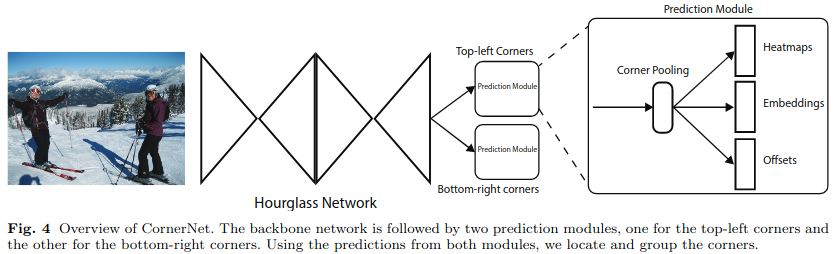

CornerNet의 keypoint를 구해야 하기 때문에 위의 그림 Figure 4와 같이 일반적인 pose estimation에서 자주 채택되는 **hourglass** 구조를 사용한다. 

### **1) heatmap**

**heatmap은 keypoint 유/무를 식별하는 용도**로 사용된다. 즉, **anchor box에 object가 존재하는지 유/무를 식별하는 것과 동일**하다고 생각하면 된다.

heatmap 두 개는 각각 top-left와 bottom-right에 존재하는데, heatmap은 **C개의 channel을 가지며 categories 수**를 의미한다. size는 H x W이다. background channel은 따로 존재하지 않는다. 또한, **각 channel은 0과 1로 corner의 위치만을 표시하는 binary mask**이다.

**positive(GT) keypoint에 radius를 설정하여 radius 범위 안에 존재하는 negative keypoint에 loss panalty를 감소**한다. (= 어느정도 GT에 근서한 keypoint를 예측했다고 판단하여 loss panalty를 감소하는 것) radius는 object의 size에 따라 결정하며, radius 주변에 gaussian distribution을 생성해 거리에 따라 loss panaly를 감소한다.

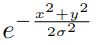

(x, y)는 positive keypoint의 좌표를 의미하며, sigma는 (radius / 3)이다.

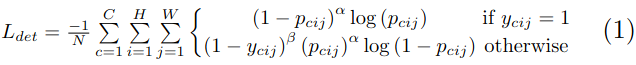

loss function은 위의 식과 같이 focal loss를 수정해 사용한다.

### **2) offset**

heatmap은 여러 convolution layer를 거쳐 down sampling이 되어있다. heatmap에서 **검출한 keypoint는 원래 이미지로 복원하는 과정에서 내림 연산에 의헤 소수점이 손실**된다.

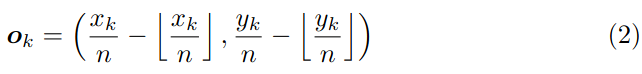

따라서 정확한 keypoint를 predict할 수 없게 되는데, 이를 해결하기 위해 offset를 계산한다.

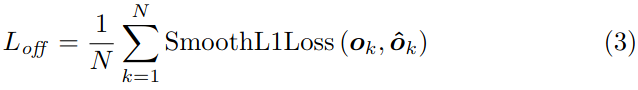

predict offset과 GT offset 사이의 loss function은 위의 식과 같이 fast r-cnn에서 처음 제안된 **SmoothL1Loss**를 사용한다.

### **Grouping Corners**

corner pooling의 예측값인 embedding은 위에서 검출한 두 쌍의 keypoints를 하나로 묶기 위해 사용한다. 두 keypoints에 대한 embedding이 생성되고, 동일한 class에 대해 keypoint embedding 사이의 distance를 측정한다. 가장 거리가 짧은 두 keypoints가 하나로 묶인다.

두 keypoints를 embedding하는 방법은 Associative Embed-
ding method(**Associative Embedding: End-to-End Learning for Joint Detection and Grouping**에서 나온 방법)를 사용한다.

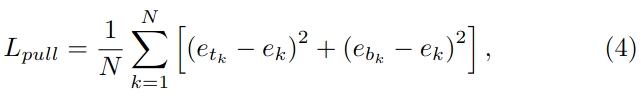

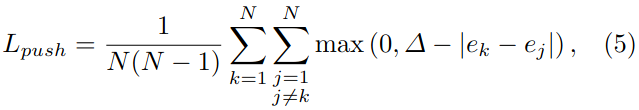

위의 식들과 같이
- 동일한 group에 속하는 keypoint에 대해서는 pull loss,
- 다른 group에 속하는 keypoint에 대해서는 push loss

를 사용한다.

위 식에서 e_tk, e_bk는 predict 값이고 e_k는 평균값이다.

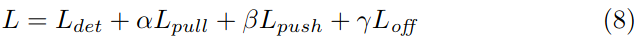

따라서 최종 loss는 위의 식과 같이 된다. 식에서 α, β, γ는 각각 loss의 가중치이다.

### **Corner Pooling**

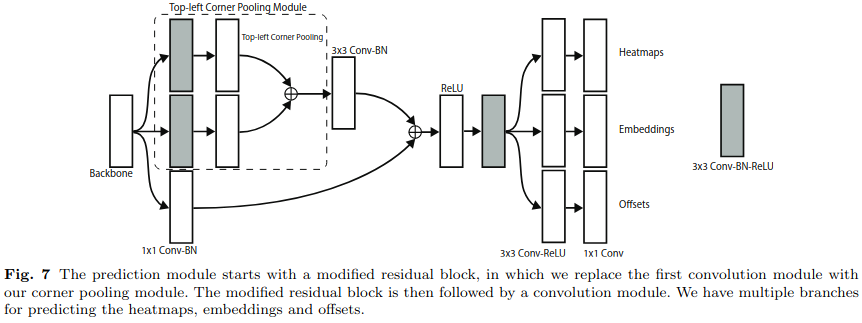

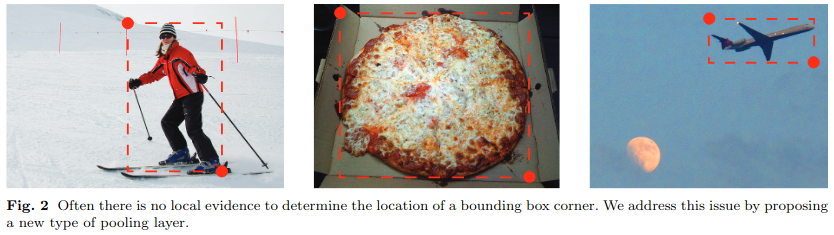

위의 그림 Figure 2에서 볼 수 있듯이 corner에 대해 local visual 증거가 없는 경우가 많다. 따라서 left corenr에서 object의 topmost에 대해 right 방향으로 수평하게 바라보고, leftmost boundary에 대해 bottom쪽을 수직으로 볼 필요가 있다.

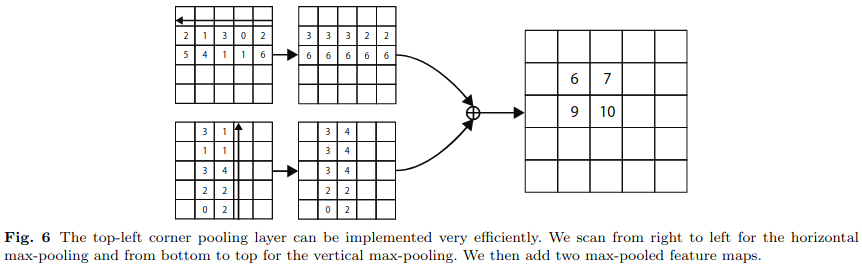

방금 설명이 잘 이해가 안가면 위의 그림 Figure 6을 보면 쉽게 이해할 수 있다.

위 과정을 통해 얻은 feature map에 convolution layer를 거쳐 heatmap, offset, embedding을 predict한다.

## **Experiments**

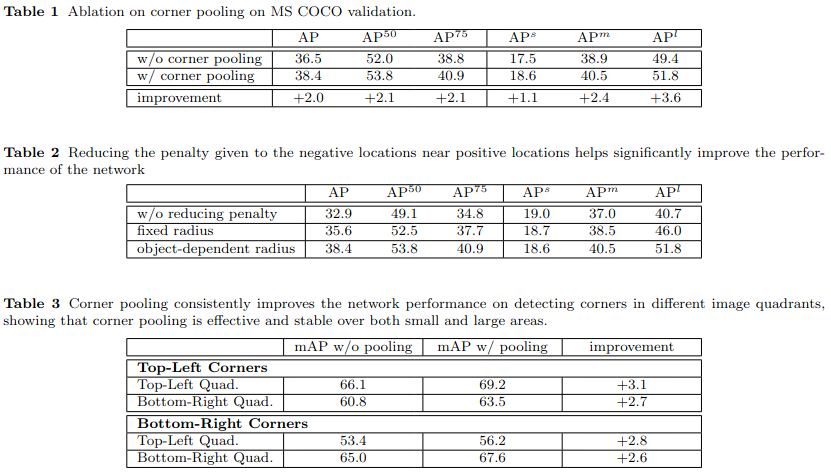

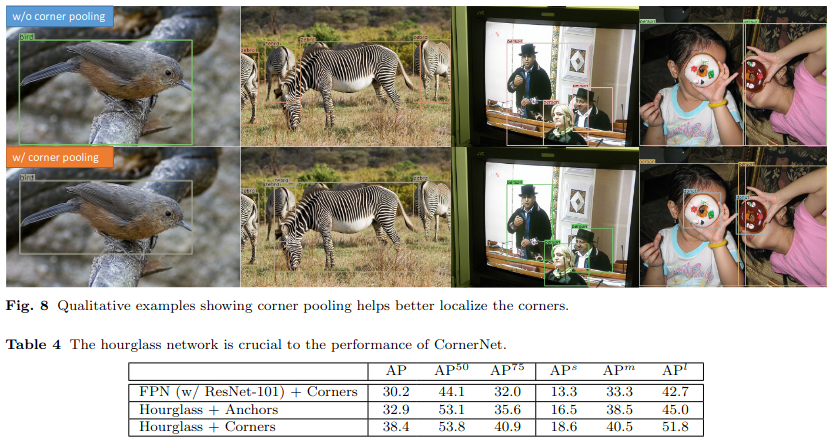